In [59]:
import ee
import geemap
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd

ee.Initialize()

# 🔹 โหลด shapefile
roi_gdf = gpd.read_file(r"C:\LT\MHSK.shp")
roi = geemap.geopandas_to_ee(roi_gdf)

years = list(range(2020, 2025))
months = list(range(1, 13))

vci_arrays = []
labels = []

ndvi_all = ee.ImageCollection('MODIS/061/MOD13Q1') \
    .filterBounds(roi) \
    .filterDate('2020-01-01', '2024-12-31') \
    .select('NDVI')

ndvi_min = ndvi_all.min().multiply(0.0001)
ndvi_max = ndvi_all.max().multiply(0.0001)

for year in years:
    for month in months:
        try:
            start = ee.Date.fromYMD(year, month, 1)
            end = start.advance(1, 'month')

            col = ndvi_all.filterDate(start, end)
            if col.size().getInfo() == 0:
                print(f"⚠️ No NDVI data for {year}-{month:02d}")
                vci_arrays.append(None)
                labels.append(f"{year}-{month:02d}")
                continue

            ndvi = col.mean().multiply(0.0001).clip(roi)

            vci = ndvi.subtract(ndvi_min).divide(ndvi_max.subtract(ndvi_min)).multiply(100).clip(roi)

            vci_np = geemap.ee_to_numpy(vci, region=roi.geometry(), scale=250)
            vci_np = np.squeeze(vci_np)

            vci_np[(vci_np < 0) | (vci_np > 100)] = np.nan
            vci_np[vci_np == 0] = np.nan

            vci_arrays.append(vci_np)
            labels.append(f"{year}-{month:02d}")
            print(f"✅ VCI loaded: {year}-{month:02d}")

        except Exception as e:
            print(f"⚠️ Error: {year}-{month:02d} → {e}")
            vci_arrays.append(None)
            labels.append(f"{year}-{month:02d}")


✅ VCI loaded: 2020-01
✅ VCI loaded: 2020-02
✅ VCI loaded: 2020-03
✅ VCI loaded: 2020-04
✅ VCI loaded: 2020-05
✅ VCI loaded: 2020-06
✅ VCI loaded: 2020-07
✅ VCI loaded: 2020-08
✅ VCI loaded: 2020-09
✅ VCI loaded: 2020-10
✅ VCI loaded: 2020-11
✅ VCI loaded: 2020-12
✅ VCI loaded: 2021-01
✅ VCI loaded: 2021-02
✅ VCI loaded: 2021-03
✅ VCI loaded: 2021-04
✅ VCI loaded: 2021-05
✅ VCI loaded: 2021-06
✅ VCI loaded: 2021-07
✅ VCI loaded: 2021-08
✅ VCI loaded: 2021-09
✅ VCI loaded: 2021-10
✅ VCI loaded: 2021-11
✅ VCI loaded: 2021-12
✅ VCI loaded: 2022-01
✅ VCI loaded: 2022-02
✅ VCI loaded: 2022-03
✅ VCI loaded: 2022-04
✅ VCI loaded: 2022-05
✅ VCI loaded: 2022-06
✅ VCI loaded: 2022-07
✅ VCI loaded: 2022-08
✅ VCI loaded: 2022-09
✅ VCI loaded: 2022-10
✅ VCI loaded: 2022-11
✅ VCI loaded: 2022-12
✅ VCI loaded: 2023-01
✅ VCI loaded: 2023-02
✅ VCI loaded: 2023-03
✅ VCI loaded: 2023-04
✅ VCI loaded: 2023-05
✅ VCI loaded: 2023-06
✅ VCI loaded: 2023-07
✅ VCI loaded: 2023-08
✅ VCI loaded: 2023-09
✅ VCI load

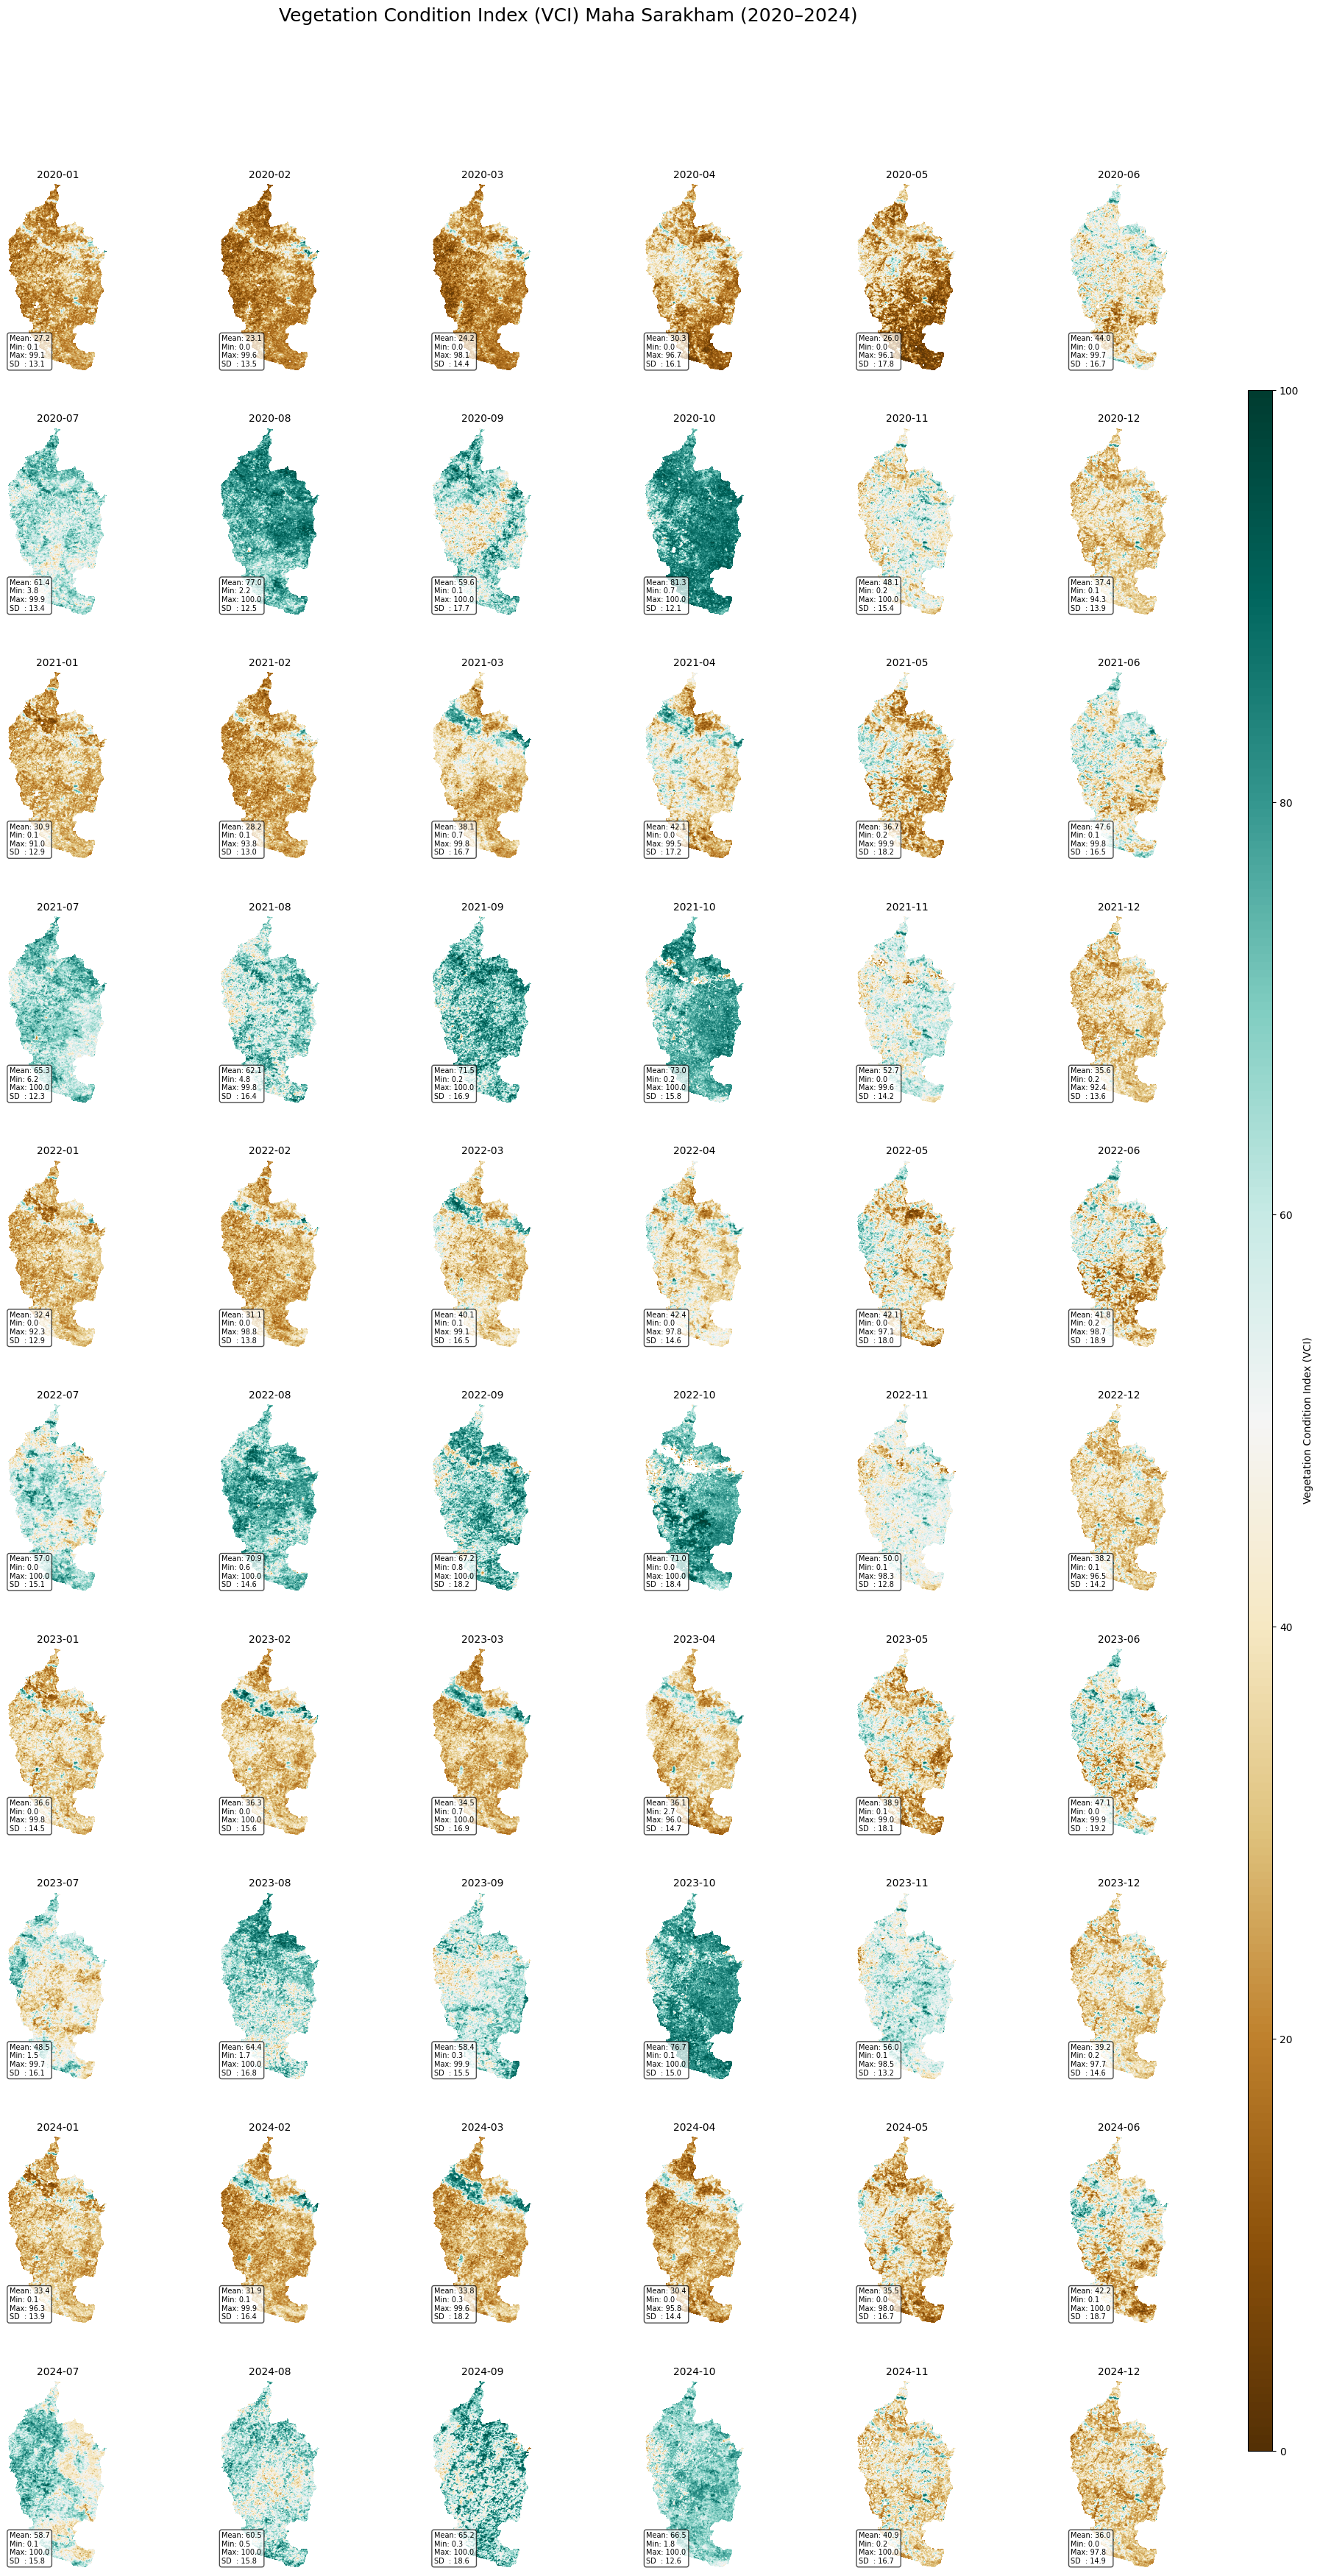

In [61]:
n_maps = len(vci_arrays)
cols = 6
rows = int(np.ceil(n_maps / cols))

fig, axes = plt.subplots(rows, cols, figsize=(22, rows * 4))
axes = axes.flatten()

for idx, ax in enumerate(axes):
    if idx >= len(vci_arrays):
        ax.axis('off')
        continue

    arr = vci_arrays[idx]
    label = labels[idx]

    if arr is None or np.all(np.isnan(arr)):
        ax.text(0.5, 0.5, "No Data", ha="center", va="center", fontsize=10)
        ax.set_title(label, fontsize=10)
        ax.axis("off")
        continue

    mean = np.nanmean(arr)
    std = np.nanstd(arr)
    min_val = np.nanmin(arr)
    max_val = np.nanmax(arr)

    im = ax.imshow(arr, cmap='BrBG', vmin=0, vmax=100)
    ax.set_title(label, fontsize=10)
    ax.axis('off')

    
    stats = f"Mean: {mean:.1f}\nMin: {min_val:.1f}\nMax: {max_val:.1f}\nSD  : {std:.1f}"
    ax.text(0.02, 0.02, stats, transform=ax.transAxes, fontsize=7,
            verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))


cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])
fig.colorbar(im, cax=cbar_ax, label='Vegetation Condition Index (VCI)')

plt.subplots_adjust(wspace=0.1, hspace=0.3, right=0.9, top=0.92)
plt.suptitle("Vegetation Condition Index (VCI) Maha Sarakham (2020–2024)", fontsize=18)
plt.show()